###

In [186]:
import numpy as np
import xarray as xr
import Functions_model2 as FM
from sklearn import preprocessing as prep 
from sklearn.model_selection import TimeSeriesSplit
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F
import scipy.signal as signal
from sklearn.model_selection import train_test_split # train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import os
import netCDF4
from tqdm import tqdm
from sklearn.decomposition import FastICA
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [50]:
# Loading data for testing
Windows_path='/mnt/c/Users/heather/Desktop/Neuromotor/Data4ML'
eeg_path=Windows_path+'/3_sessions_eeg_filtered'
joint_path=Windows_path+'/3_sessions_joint'
velocity_path=Windows_path+'/3_session_velocity'

In [193]:
# Selects only the first trial for test run
eeg_data=xr.load_dataset(eeg_path)
eeg_=eeg_data.isel(Trial=0).copy()
eeg=eeg_.__xarray_dataarray_variable__
eeg=np.array(eeg.values)

joint_data=xr.load_dataset(joint_path)
joint_=joint_data.isel(Trial=0).copy()
joint=joint_.__xarray_dataarray_variable__
joint=np.array(joint.values)

velocity_data=xr.load_dataset(velocity_path)
velocity_=velocity_data.isel(Trial=0).copy()
velocity=velocity_.__xarray_dataarray_variable__
velocity=np.array(velocity.values)

In [194]:
def joint_2_velocity(joint_angles,fs): 
    velocity=np.diff(joint_angles, axis=0)*100
    return velocity

In [195]:
velocity_joint=joint_2_velocity(joint,100)
print(np.isnan(velocity_joint).any())
print(velocity_joint.shape)


False
(89999, 6)


In [196]:
eeg,velocity_joint=FM.align_data_by_offset_joint(eeg,velocity_joint,5)
eeg,velocity=FM.align_data_by_offset(eeg,velocity,5)

In [197]:
def velocity_rescaler(data):
    min_max_scaler = prep.MinMaxScaler() 
    for i in range(data.shape[1]):
        channel=data[:,i]
        data_2d = channel.reshape(-1, 1)
        normalizedData = min_max_scaler.fit_transform(data_2d) 
        normalized_data = normalizedData.flatten()
        data[:,i]=normalized_data
    return data

In [198]:
velocity.shape[1]

6

In [199]:
velocity_joint=FM.lp(velocity_joint,0.05)
velocity=FM.lp(velocity,0.05)

In [200]:
ica = FastICA(n_components=1) 
for i in range(velocity.shape[1]):
    velocity[:, i] = ica.fit_transform(velocity[:, i].reshape(-1, 1)).flatten()

In [201]:
velocity_joint,scalerj =FM.velocity_rescaler(velocity_joint)
velocity,scalerV =FM.velocity_rescaler(velocity)
print(np.max(velocity))

1.0


In [202]:
def filter_and_interpolate(data, threshold=0.08):
    # Compute the absolute differences between adjacent points
    diff = np.abs(np.diff(data))
    
    # Identify indices where the difference exceeds the threshold
    bad_indices = np.where(diff > threshold)[0] + 1
    
    # Create a mask to identify valid points
    mask = np.ones(len(data), dtype=bool)
    mask[bad_indices] = False
    
    # Interpolate using valid points
    interp_func = interp.interp1d(np.flatnonzero(mask), data[mask], kind='linear', fill_value="extrapolate")
    
    # Replace bad points with interpolated values
    data[bad_indices] = interp_func(bad_indices)
    
    return data

In [203]:
for i in range(velocity.shape[1]):
    velocity[:, i] = filter_and_interpolate(velocity[:, i])

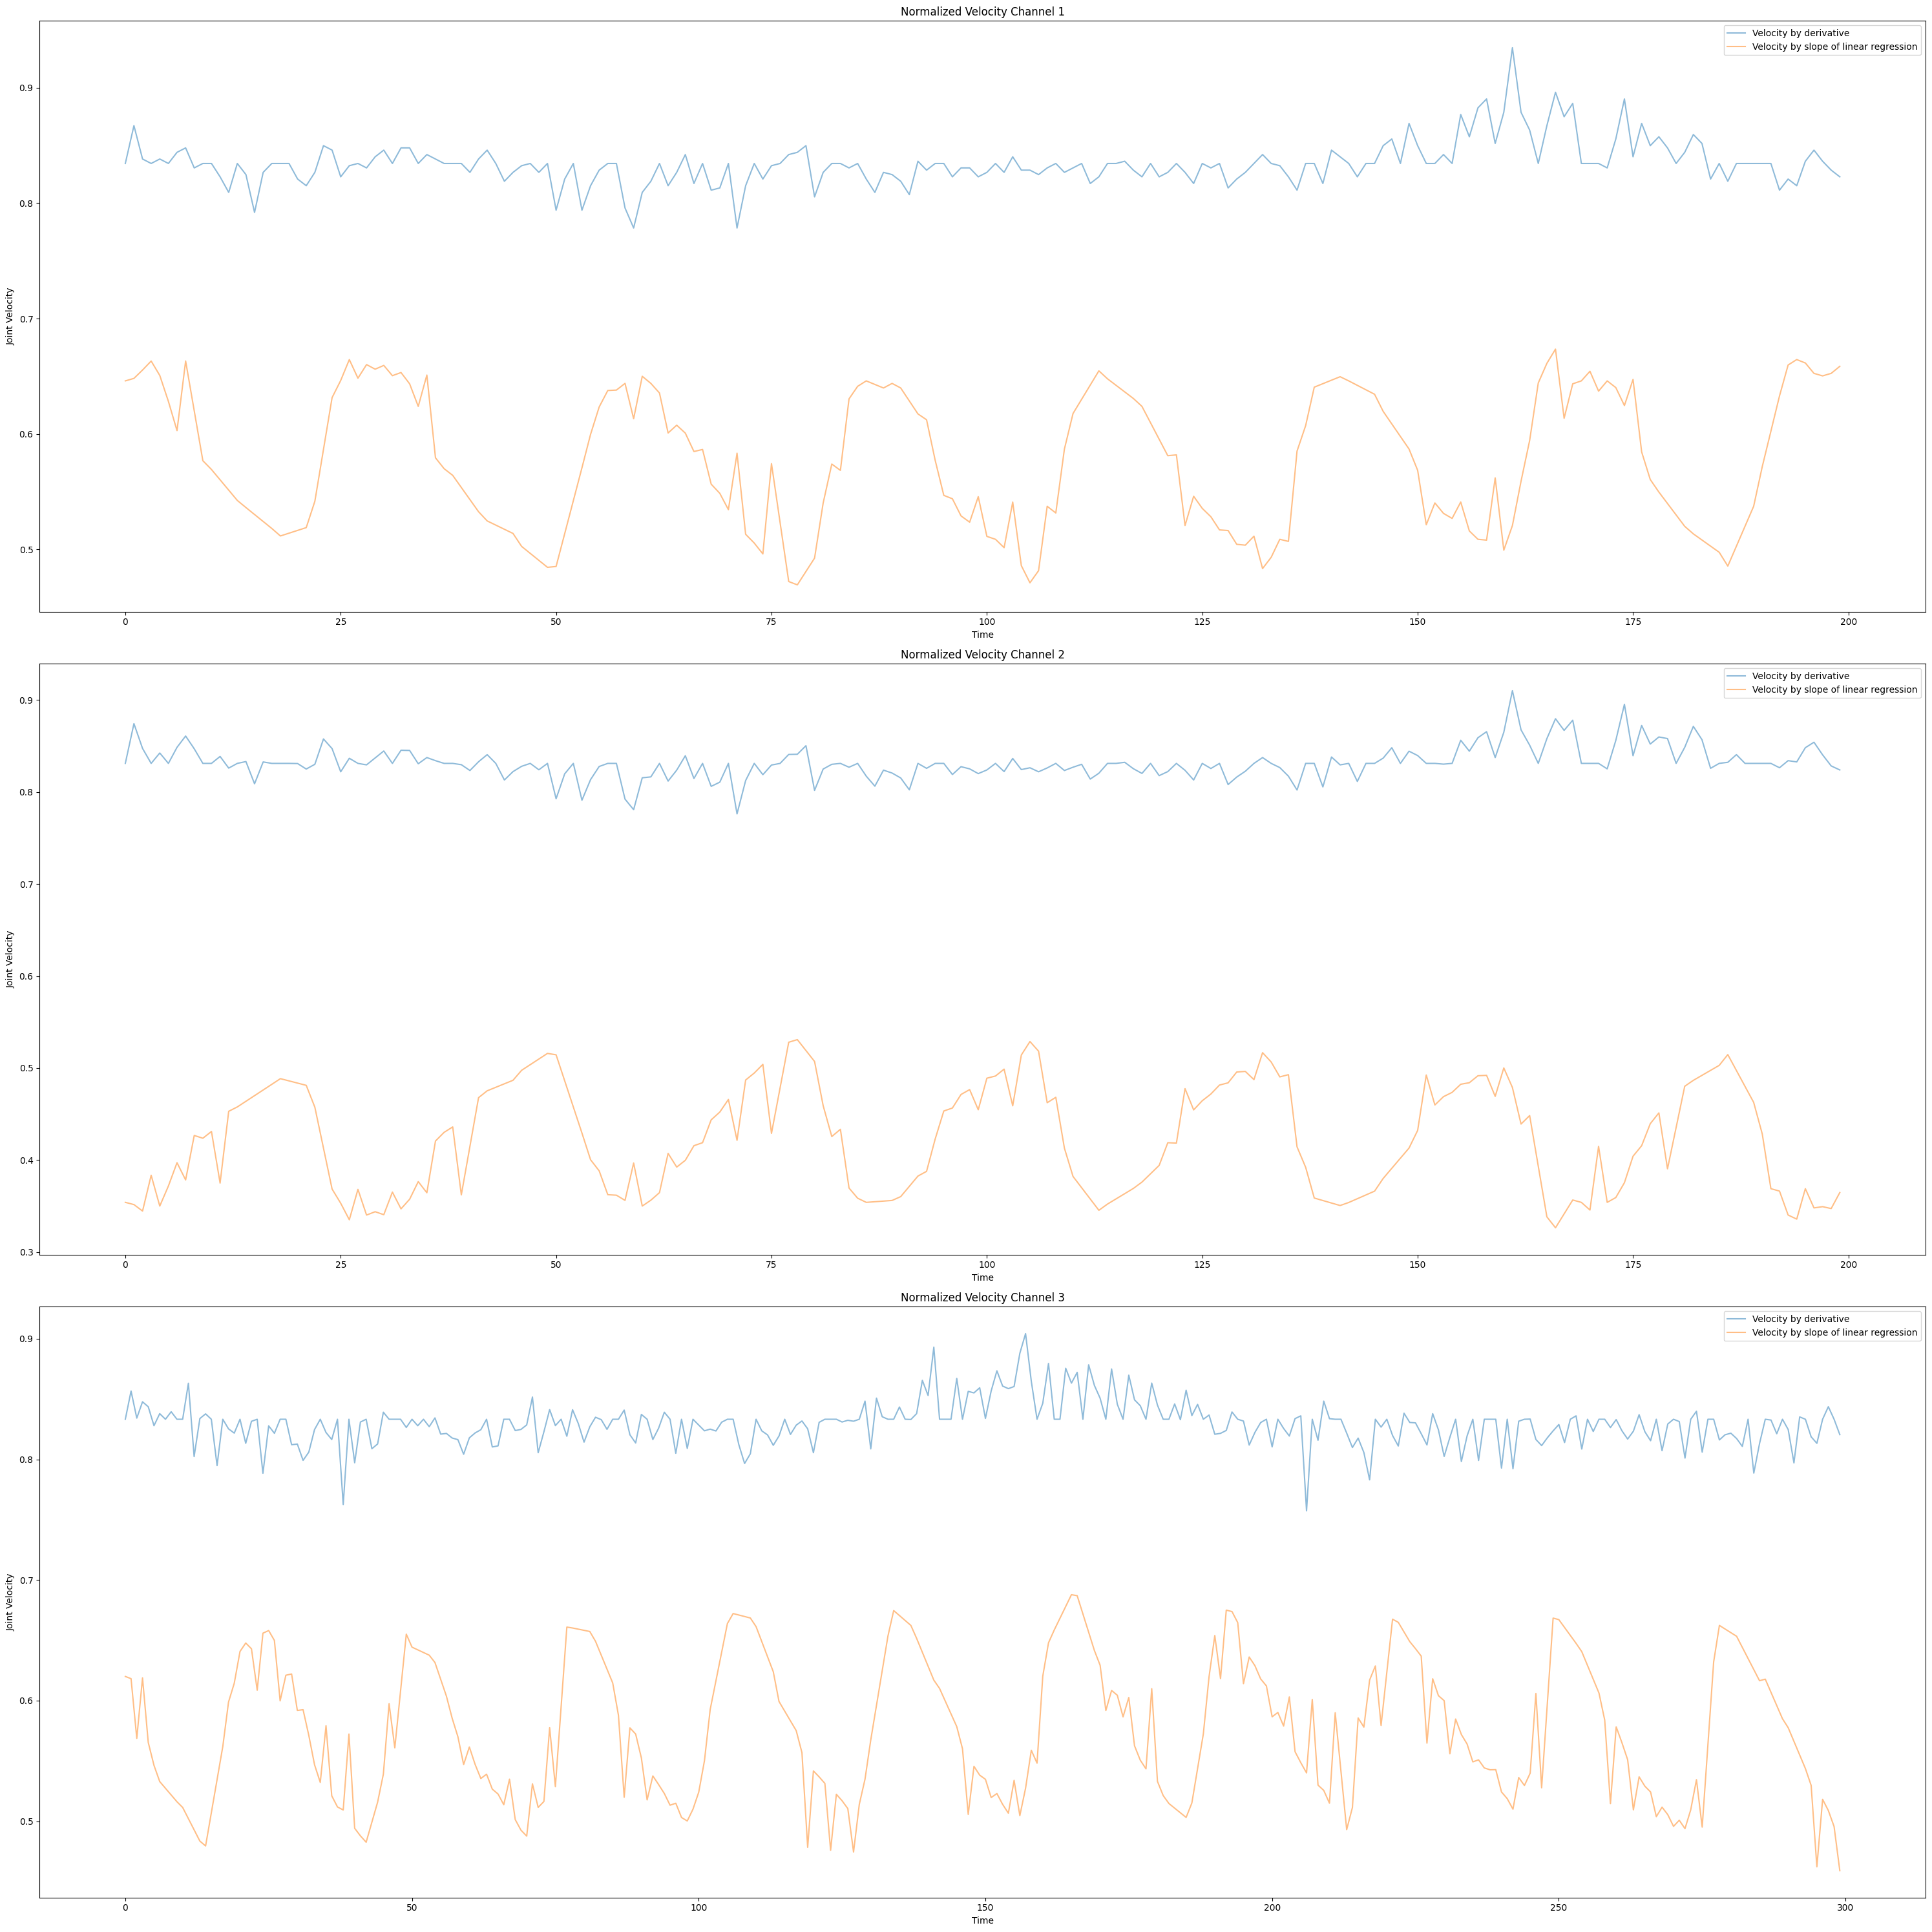

In [204]:
plt.figure(figsize=(30, 30))
plt.subplot(3, 1, 1)
plt.plot(velocity_joint[:200, 0], label='Velocity by derivative', alpha=0.5)
plt.plot(velocity[:200, 0], label='Velocity by slope of linear regression', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Joint Velocity')
plt.title('Normalized Velocity Channel 1')

plt.subplot(3, 1, 2)
plt.plot(velocity_joint[:200, 1], label='Velocity by derivative', alpha=0.5)
plt.plot(velocity[:200, 1], label='Velocity by slope of linear regression', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Joint Velocity')
plt.title('Normalized Velocity Channel 2')

plt.subplot(3, 1, 3)
plt.plot(velocity_joint[:200, 2], label='Velocity by derivative', alpha=0.5)
plt.plot(velocity[:200, 2], label='Velocity by slope of linear regression', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Joint Velocity')
plt.title('Normalized Velocity Channel 3')

plt.tight_layout()
plt.savefig('Joint Velocity.png', dpi=300)

In [59]:
def apply_stft(eeg_filtered, fs=100, window='hann', nperseg=10):
    result = []
    for channel in range(eeg_filtered.shape[1]):
        f, t, Zxx = signal.stft(eeg_filtered[:, channel], fs=fs, window=window, nperseg=nperseg)
        result.append(Zxx)
    result = np.array(result)
    return result, t

def velocity_windower(velocity, time, window_size=1):
    n_samples = len(time)
    if n_samples == 0:
        return np.array([])  # Return an empty array if time is empty
    window_indices = [idx for idx in range(0, n_samples - window_size + 1, window_size)]
    y = np.array([velocity[idx: idx + window_size] for idx in window_indices])  # output data
    return y.reshape(y.shape[0], y.shape[-1])  # Flatten dimension=1

In [60]:
stft_data,t= apply_stft(eeg)
stft_data_reshaped = stft_data.transpose(2, 0, 1) # reshape the STFT data
X = stft_data_reshaped # input data
y = velocity_windower(velocity,t)
print(f'X: {X.shape}, y: {y.shape},  time: {t.shape}')

X: (17999, 60, 6), y: (17999, 6),  time: (17999,)


In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # set the device
print(f'Device: {device}')

Device: cpu


In [62]:


def train_val_test_split(X, y, val_size=0.2, test_size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [63]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, val_size=val_size, test_size=test_size) # split the data

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (14579, 60, 6), y_train: (14579, 6)
X_val: (1620, 60, 6), y_val: (1620, 6)
X_test: (1800, 60, 6), y_test: (1800, 6)


In [64]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Add dropout layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)  # Apply dropout
        out = self.fc(out[:, -1, :])
        return out

# hyperparameters
input_size = X_train.shape[2] # number of features
hidden_size = 60 # number of hidden units
num_layers = 2 # number of LSTM layers
num_classes = y_train.shape[1] # number of output classes
dropout = 0.7 # dropout

model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, dropout=dropout).to(device)

In [65]:
# data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=list(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

for i, (X_batch, y_batch) in enumerate(train_loader):
    print(f'X_batch: {X_batch.shape}, y_batch: {y_batch.shape}')
    break

X_batch: torch.Size([32, 60, 6]), y_batch: torch.Size([32, 6])


In [66]:
%%time

criteria = nn.MSELoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)# optimizer

num_epochs = 400 # number of epochs
train_losses, val_losses = [], []
train_rmse, val_rmse = [], []

early_stopping = 200
best_val_loss = np.inf
not_improved = 0

# train the model
for epoch in range(num_epochs):
    model.train()
    total_loss, total_samples = 0, 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        outputs = model(inputs)
        loss = criteria(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
    train_losses.append(total_loss / total_samples)
    train_rmse.append(np.sqrt(train_losses[-1]))

    model.eval()
    total_loss, total_samples = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device).float()
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    current_val_loss = total_loss / total_samples
    val_losses.append(current_val_loss)
    val_rmse.append(np.sqrt(val_losses[-1]))

    # Early stopping check
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping:
            print("Early stopping triggered")
            break

    print(f'Epoch {epoch + 1}: Train RMSE: {train_rmse[-1]}, Val RMSE: {val_rmse[-1]}')

Epoch 1/400: 100%|██████████| 456/456 [00:05<00:00, 81.12it/s]


Epoch 1: Train RMSE: 0.011340424892149656, Val RMSE: 0.0015954102699031634


Epoch 2/400: 100%|██████████| 456/456 [00:05<00:00, 89.46it/s]


Epoch 2: Train RMSE: 0.00167436307071713, Val RMSE: 0.0015387474184053208


Epoch 3/400: 100%|██████████| 456/456 [00:05<00:00, 90.68it/s]


Epoch 3: Train RMSE: 0.0016385284969537043, Val RMSE: 0.0015337722097533684


Epoch 4/400: 100%|██████████| 456/456 [00:05<00:00, 85.94it/s]


Epoch 4: Train RMSE: 0.0016026956890196524, Val RMSE: 0.0015385213157587186


Epoch 5/400: 100%|██████████| 456/456 [00:05<00:00, 84.22it/s]


Epoch 5: Train RMSE: 0.0016043930077733906, Val RMSE: 0.0016081124477713262


Epoch 6/400: 100%|██████████| 456/456 [00:05<00:00, 89.07it/s]


Epoch 6: Train RMSE: 0.001613199558371181, Val RMSE: 0.0015501115897541622


Epoch 7/400: 100%|██████████| 456/456 [00:05<00:00, 76.98it/s]


Epoch 7: Train RMSE: 0.0016050456917726264, Val RMSE: 0.0015710492757147647


Epoch 8/400: 100%|██████████| 456/456 [00:05<00:00, 77.06it/s]


Epoch 8: Train RMSE: 0.0015932097690783834, Val RMSE: 0.0016435873735627464


Epoch 9/400: 100%|██████████| 456/456 [00:06<00:00, 72.72it/s]


Epoch 9: Train RMSE: 0.001598815042638342, Val RMSE: 0.001537353848157816


Epoch 10/400: 100%|██████████| 456/456 [00:07<00:00, 64.34it/s]


Epoch 10: Train RMSE: 0.0015813121445890177, Val RMSE: 0.0015589208063308414


Epoch 11/400: 100%|██████████| 456/456 [00:07<00:00, 63.51it/s]


Epoch 11: Train RMSE: 0.0015741566917894724, Val RMSE: 0.0015178145166880933


Epoch 12/400: 100%|██████████| 456/456 [00:19<00:00, 22.81it/s]


Epoch 12: Train RMSE: 0.0015586485947754742, Val RMSE: 0.0015486089618099248


Epoch 13/400: 100%|██████████| 456/456 [00:13<00:00, 33.47it/s]


Epoch 13: Train RMSE: 0.0015542178545813591, Val RMSE: 0.0015415560565223076


Epoch 14/400: 100%|██████████| 456/456 [00:08<00:00, 55.88it/s]


Epoch 14: Train RMSE: 0.001546899374878748, Val RMSE: 0.0015100123782091253


Epoch 15/400: 100%|██████████| 456/456 [00:13<00:00, 34.78it/s]


Epoch 15: Train RMSE: 0.0015326239566517564, Val RMSE: 0.0015245706497700683


Epoch 16/400: 100%|██████████| 456/456 [00:10<00:00, 41.55it/s]


Epoch 16: Train RMSE: 0.0015181453512621633, Val RMSE: 0.0015793064586004108


Epoch 17/400: 100%|██████████| 456/456 [00:09<00:00, 47.43it/s]


Epoch 17: Train RMSE: 0.001521458599573526, Val RMSE: 0.0016119302153042962


Epoch 18/400: 100%|██████████| 456/456 [00:06<00:00, 72.13it/s]


Epoch 18: Train RMSE: 0.0015088830164273833, Val RMSE: 0.001536134026619149


Epoch 19/400: 100%|██████████| 456/456 [00:07<00:00, 64.81it/s]


Epoch 19: Train RMSE: 0.0015090798847630091, Val RMSE: 0.001511934071308506


Epoch 20/400: 100%|██████████| 456/456 [00:10<00:00, 43.30it/s]


Epoch 20: Train RMSE: 0.0015035382468364434, Val RMSE: 0.001584416858252244


Epoch 21/400: 100%|██████████| 456/456 [00:13<00:00, 33.97it/s]


Epoch 21: Train RMSE: 0.0015050099460345323, Val RMSE: 0.0015087029416777202


Epoch 22/400: 100%|██████████| 456/456 [00:07<00:00, 60.03it/s]


Epoch 22: Train RMSE: 0.0015032294748466807, Val RMSE: 0.0015277079606998826


Epoch 23/400: 100%|██████████| 456/456 [00:07<00:00, 59.90it/s]


Epoch 23: Train RMSE: 0.0015016658763857887, Val RMSE: 0.0015543898274306533


Epoch 24/400: 100%|██████████| 456/456 [00:08<00:00, 56.37it/s]


Epoch 24: Train RMSE: 0.0015062716961479513, Val RMSE: 0.001512052947581785


Epoch 25/400: 100%|██████████| 456/456 [00:07<00:00, 58.08it/s]


Epoch 25: Train RMSE: 0.0015049723976464531, Val RMSE: 0.0015137318297340347


Epoch 26/400: 100%|██████████| 456/456 [00:07<00:00, 60.30it/s]


Epoch 26: Train RMSE: 0.001505851386761775, Val RMSE: 0.0015104979943641702


Epoch 27/400: 100%|██████████| 456/456 [00:07<00:00, 64.65it/s]


Epoch 27: Train RMSE: 0.001504916756651338, Val RMSE: 0.0015650475225928362


Epoch 28/400: 100%|██████████| 456/456 [00:06<00:00, 67.67it/s]


Epoch 28: Train RMSE: 0.001503284299899339, Val RMSE: 0.0015314685101669924


Epoch 29/400:  74%|███████▎  | 336/456 [00:05<00:01, 62.99it/s]


KeyboardInterrupt: 

In [ ]:
# test accuracy
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        outputs = model(inputs)
        test_loss = criteria(outputs, labels)
    print(f'Test Loss: {test_loss.item()}')

In [ ]:
# plot the training and validation loss
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(val_losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(train_losses)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title('Training Loss')

plt.tight_layout()
plt.show()

In [ ]:
# plot the training and validation RMSE
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(val_rmse)
plt.ylabel('RMSE')
plt.xlabel('Iteration')
plt.title('Validation RMSE')

plt.subplot(2, 1, 2)
plt.plot(train_rmse)
plt.ylabel('RMSE')
plt.xlabel('Iteration')
plt.title('Training RMSE')

plt.tight_layout()
plt.savefig('TrainingValidationRMSE.png', dpi=300)